In [1]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 15})

Let's look at a summary of the packet loss over a 6-month period. Using a boxplot (similar to LatencySummary notebook), we can look at the packet loss distribution of each link over time to get a feel for how unstable each link's packet loss is.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan

#Create instance of ElasticSearch using the Atlas host server
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],
                   timeout=60)

In [3]:
linkName = ['Australia-ATLAS', 'Taiwan-LCG2', 'BEIJING-LCG2', 'SPRACE',
            'T2-TH-CUNSTDA','EELA-UTFSM', 'TOKYO-LCG2', 'CA-VICTORIA-WESTGRID-T2',
            'ITEP', 'SFU-LCG2','TRIUMF-LCG2', 'UFlorida-HPC', 'UTA_SWT2',
            'SARA-MATRIX', 'WT2', 'INDIACMS-TIFR', 'BU_ATLAS_Tier2', 'LUCILLE',
            'OU_OCHEP_SWT2', 'Nebraska', 'MWT2', 'AGLT2', 'GLOW', 'Vanderbilt',
            'CA-SCINET-T2', 'ru-PNPI', 'BNL-ATLAS', 'RRC-KI',
            'CA-MCGILL-CLUMEQ-T2', 'AM-04-YERPHI', 'CYFRONET-LCG2', 'RRC-KI-T1',
            'CSCS-LCG2', 'RU-Protvino-IHEP', 'RAL-LCG2', 'JINR-T1', 'INFN-BARI',
            'FMPhI-UNIBA', 'JINR-LCG2', 'INFN-ROMA1', 'pic', 'RO-16-UAIC', 
            'FI_HIP_T2', 'RO-07-NIPNE', 'RO-02-NIPNE', 'IFCA-LCG2', 'DESY-ZN',
            'INFN-NAPOLI-ATLAS', 'BEgrid-ULB-VUB', 'DESY-HH',
            'UKI-NORTHGRID-LANCS-HEP', 'NDGF-T1', 'INFN-T1', 'IN2P3-LPC',
            'IEPSAS-Kosice', 'IFIC-LCG2', 'UKI-SCOTGRID-GLASGOW',
            'UKI-NORTHGRID-LIV-HEP', 'BUDAPEST', 'UKI-SCOTGRID-ECDF',
            'UKI-SCOTGRID-DURHAM', 'FZK-LCG2', 'UKI-SOUTHGRID-OX-HEP',
            'UAM-LCG2', 'UKI-NORTHGRID-MAN-HEP', 'UKI-SOUTHGRID-CAM-HEP',
            'UKI-SOUTHGRID-SUSX', 'INFN-FRASCATI', 'UKI-SOUTHGRID-BHAM-HEP',
            'IN2P3-CPPM', 'UKI-LT2-QMUL', 'praguelcg2', 'UKI-SOUTHGRID-RALPP',
            'GoeGrid', 'UKI-LT2-UCL-HEP', 'GRIF', 'wuppertalprod', 'IN2P3-LAPP',
            'IN2P3-LPSC', 'INFN-MILANO-ATLASC', 'IN2P3-CC']

In [34]:
import ast


query = '''{
  "size": 0,
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "srcSite:CERN* AND destSite:%s* AND packet_loss:>=0",
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "timestamp": {
                  "gte": 1452689502533,
                  "lte": 1468410702533,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "aggs": {
    "2": {
      "date_histogram": {
        "field": "timestamp",
        "interval": "1d",
        "time_zone": "Europe/Berlin",
        "min_doc_count": 1,
        "extended_bounds": {
          "min": 1452689502532,
          "max": 1468410702533
        }
      },
      "aggs": {
        "1": {
          "avg": {
            "field": "packet_loss"
          }
        }
      }
    }
  }
}'''

packetLossData = []
totalEpochTime = []

for i in range(len(linkName)):
    query2 = ast.literal_eval(query%(linkName[i]))
    response = es.search(index="network_weather_2-*", body=query2, request_timeout=600)
    packetLoss = []
    epochTime = []

    for r in response['aggregations']['2']['buckets']:
        #Get field value and timestamp
        packetLoss.append(r['1']['value'])
        epochTime.append(r['key'])
    
    packetLoss = np.array(packetLoss,dtype=np.float)
    epochTime = np.array(epochTime,dtype=np.float)

    indices = np.logical_not(np.isnan(packetLoss))

    packetLoss = packetLoss[indices]
    epochTime = epochTime[indices]
    
    packetLossData.append(packetLoss)
    totalEpochTime.append(epochTime)    


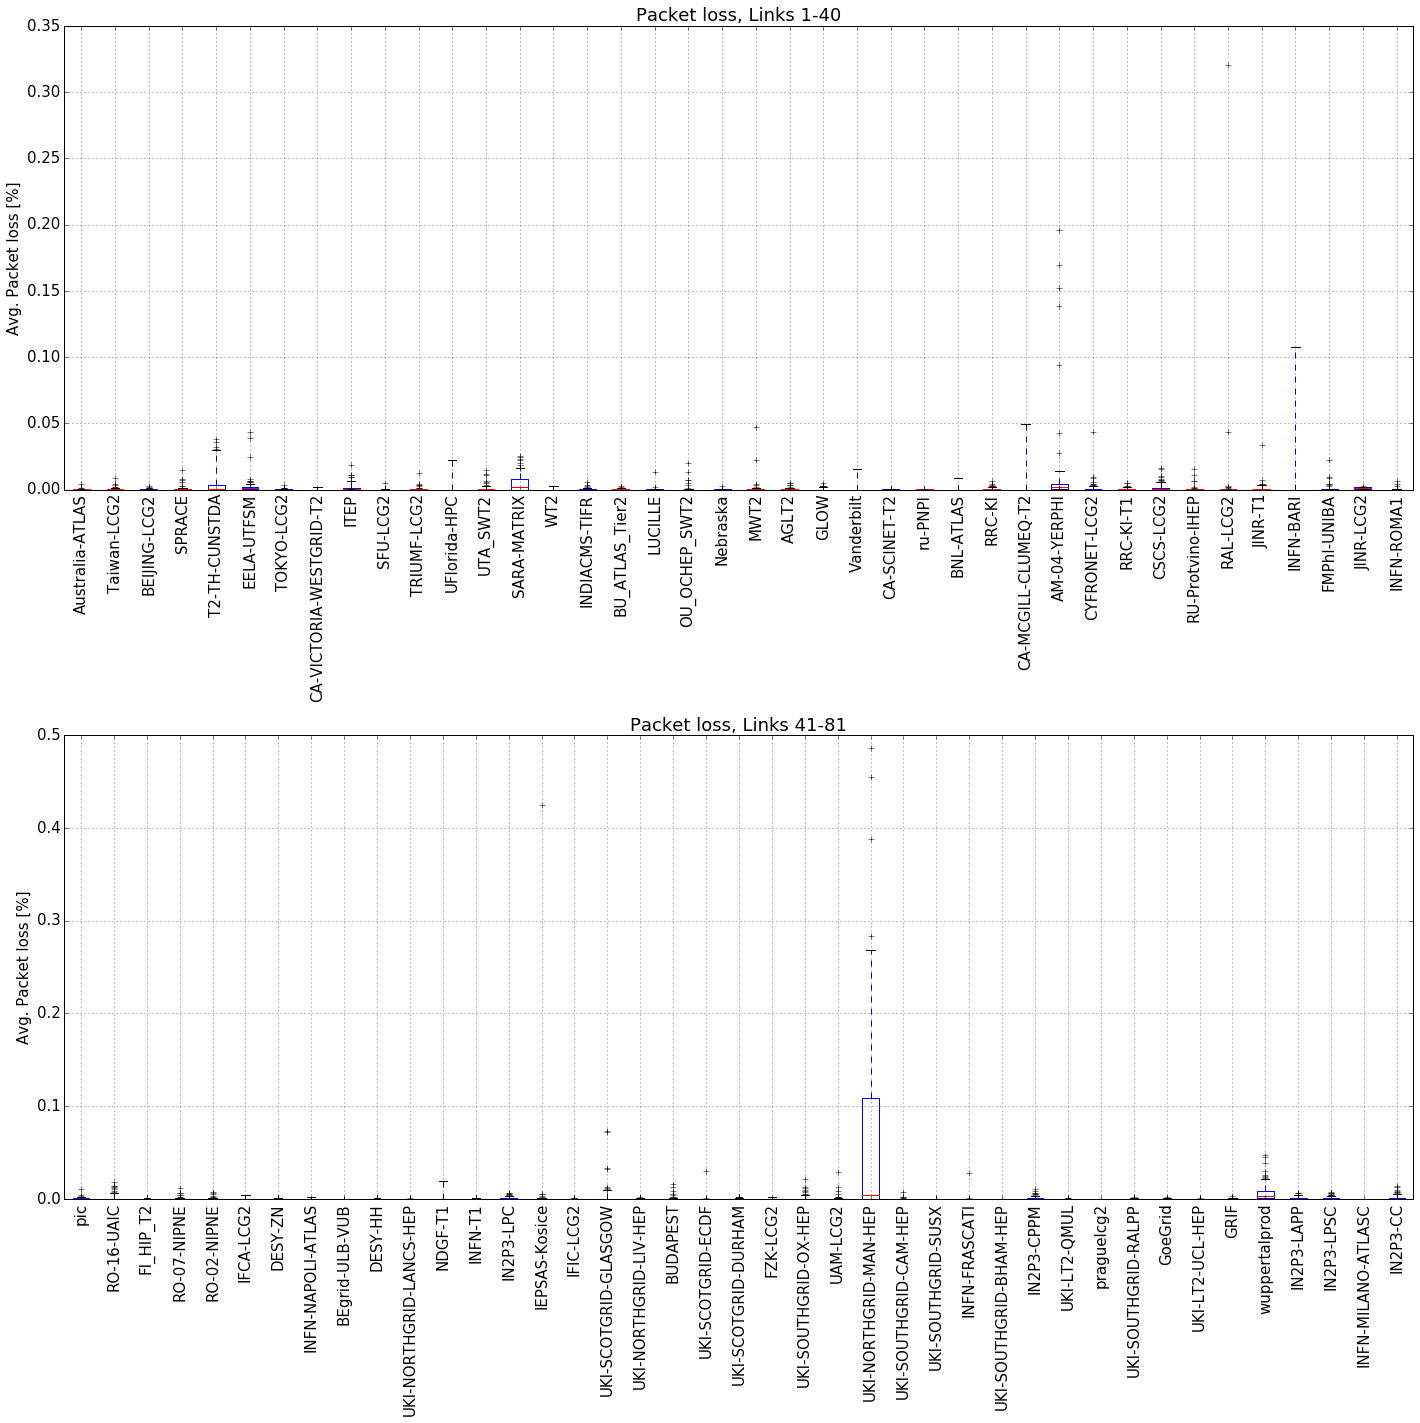

In [51]:
plt.figure(figsize=(20,20))

plt.subplot(211)
plt.boxplot(packetLossData[0:40], whis=[5,95], showfliers=True)
ax = plt.gca() 
ax.xaxis.set_ticklabels(linkName[0:40])
plt.xticks(size=15,rotation= 90)
plt.grid()
plt.ylabel('Avg. Packet loss [%]')
plt.title('Packet loss, Links 1-40')

plt.subplot(212)
plt.boxplot(packetLossData[40:], whis=[5,95], showfliers=True)
ax = plt.gca() 
ax.xaxis.set_ticklabels(linkName[40:])
plt.xticks(size=15,rotation= 90)
plt.ylabel('Avg. Packet loss [%]')
plt.title('Packet loss, Links 41-81')
plt.grid()

plt.tight_layout()

In [36]:
histPacketLoss= dict(zip(linkName, packetLossData))
histTime = dict(zip(linkName, totalEpochTime))

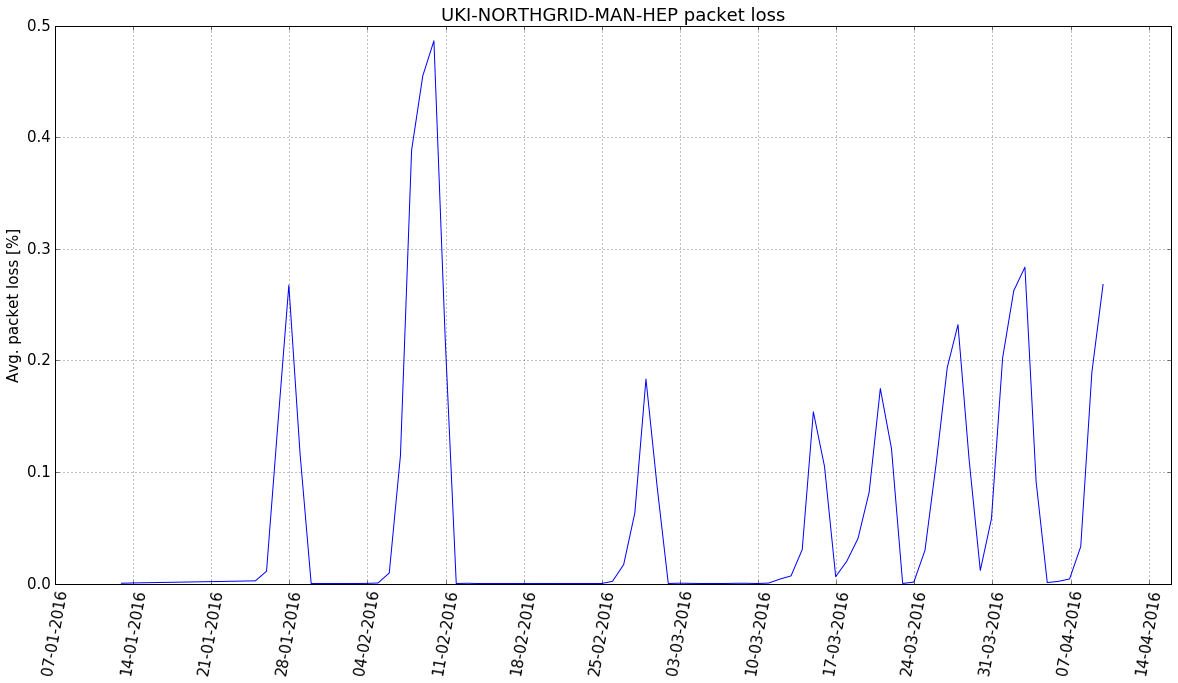

In [52]:
import matplotlib.dates as dt

centerName = 'UKI-NORTHGRID-MAN-HEP'

timestamp = dt.epoch2num(histTime[centerName]/1000.)
packetLoss = histPacketLoss[centerName]

plt.figure(figsize=(20,10))
plt.plot(timestamp,packetLoss)

ax = plt.gca()
#Tedious date/time formatting
xfmt = dt.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis_date()

plt.ylabel('Avg. packet loss [%]')

#Manually add extra ticks to histogram plots
ticks = 7
start, end = ax.get_xlim()
plt.xticks(np.arange(start, end,ticks),rotation= 80 )
plt.grid()
plt.title('%s packet loss'%centerName)
plt.show()